In [22]:
import random
from collections import OrderedDict
import tqdm
import math
import time
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
from scripts.smallNNClassification import NetClass
from scripts.smallNNRegression import NetRegr
from scripts.Metropolis import *
from scripts.mcmc_samplers import *

# Metropolis

## Classification

In [4]:
data = np.loadtxt('dataSimple/example_data.txt', delimiter=',')
X = data[:,0]
y = data[:,2]

X = np.reshape(X,(X.shape[0],1))
y = np.reshape(y, (y.shape[0],1))

X, y = torch.from_numpy(X).type(torch.FloatTensor), torch.from_numpy(y).type(torch.FloatTensor)

N = X.shape[0] 
M = 280
a, b = np.floor(min(X)), np.ceil(max(X))    
Xtest = torch.from_numpy(np.linspace(a-2, b+2, M).reshape(-1,1)).type(torch.FloatTensor)

In [6]:
model = NetClass()
loss_fn = torch.nn.BCELoss(reduction='sum')
m = Metropolis(model, (X,y),loss_fn, 0.004, 100000)
history = m.run()

Initial Loss 88.87509155273438
Iteration 20000/100000: 0.0s, Loss: 28.358308792114258, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 55.95
Iteration 40000/100000: 0.0s, Loss: 28.46859359741211, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 45.8675
Iteration 60000/100000: 0.0s, Loss: 30.557323455810547, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 38.895
Iteration 80000/100000: 0.0s, Loss: 29.810726165771484, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 34.46375
Iteration 100000/100000: 0.0s, Loss: 56.439247131347656, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 31.291


In [7]:
params = history['model_parameters'][3000::100]
outputs = torch.zeros((Xtest.size()[0], len(params)))
print(len(params))
for i,set_param in enumerate(params):
    state_dict_it = OrderedDict(set_param)
    model.load_state_dict(state_dict_it, strict=False) 
    with torch.no_grad():
        outputs[:,i] = torch.squeeze(model(Xtest))
percentile5, percentile95 = np.percentile(outputs.numpy(),5, axis=1), np.percentile(outputs.numpy(),95, axis=1)
mean = torch.mean(outputs, 1)

971


## Regression

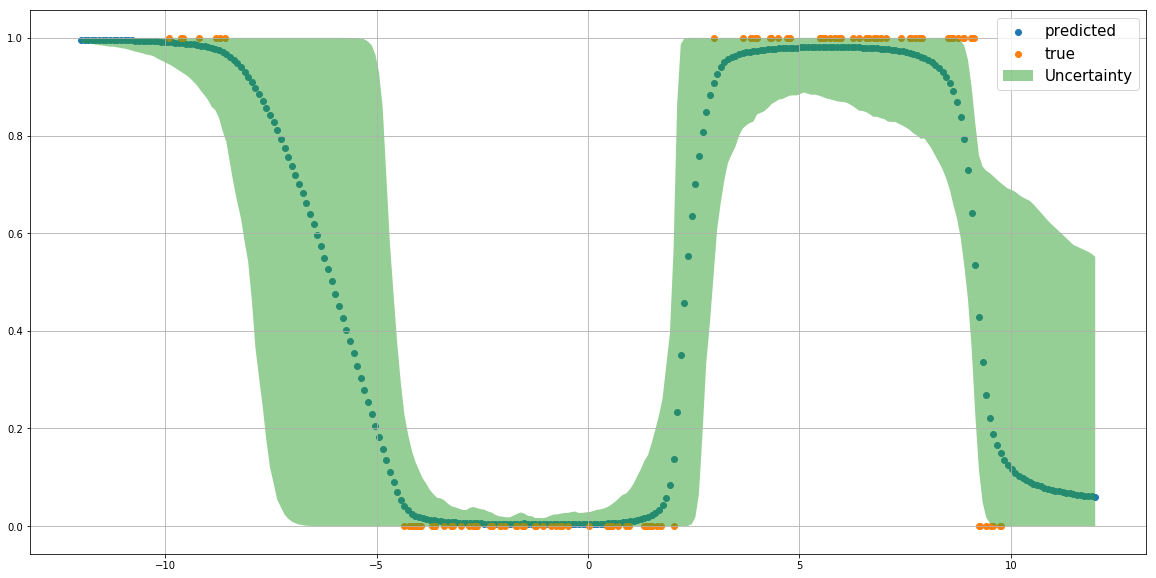

In [11]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.grid()
plt.scatter(Xtest, mean, label='predicted')
plt.scatter(X, y, label='true')
plt.fill_between(np.array(Xtest).ravel(), 
                 percentile5,
                 percentile95,
                 alpha=0.5, label='Uncertainty')
plt.legend(fontsize=15)
plt.savefig("imgs/MetropolisClassification.png")
plt.show()

In [12]:
data = np.loadtxt('dataSimple/example_data.txt', delimiter=',')
X = data[:,0]
y = data[:,1]

X = np.reshape(X,(X.shape[0],1))
y = np.reshape(y, (y.shape[0],1))

X, y = torch.from_numpy(X).type(torch.FloatTensor), torch.from_numpy(y).type(torch.FloatTensor)

N = X.shape[0] 
M = 280
a, b = np.floor(min(X)), np.ceil(max(X))    
Xtest = torch.from_numpy(np.linspace(a-2, b+2, M).reshape(-1,1)).type(torch.FloatTensor)

In [13]:
model = NetRegr()
loss_fn = torch.nn.MSELoss(reduction='sum')
m = Metropolis(model, (X,y),loss_fn, 0.005, 100000)

In [14]:
history = m.run()

Initial Loss 412.44012451171875
Iteration 20000/100000: 0.0s, Loss: 23.15465545654297, Minor Loss: False, Accepted: True, Current Acceptance Ratio: 34.17
Iteration 40000/100000: 0.0s, Loss: 33.80804443359375, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 25.735
Iteration 60000/100000: 0.0s, Loss: 29.291004180908203, Minor Loss: False, Accepted: True, Current Acceptance Ratio: 20.955
Iteration 80000/100000: 0.0s, Loss: 48.281524658203125, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 18.09125
Iteration 100000/100000: 0.0s, Loss: 72.85963439941406, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 15.886


In [15]:
params = history['model_parameters'][3000::100]
outputs = torch.zeros((Xtest.size()[0], len(params)))
for i,set_param in enumerate(params):
    state_dict_it = OrderedDict(set_param)
    model.load_state_dict(state_dict_it, strict=False) 
    with torch.no_grad():
        outputs[:,i] = torch.squeeze(model(Xtest))
percentile5, percentile95 = np.percentile(outputs.numpy(),5, axis=1), np.percentile(outputs.numpy(),95, axis=1)
mean = torch.mean(outputs, 1)

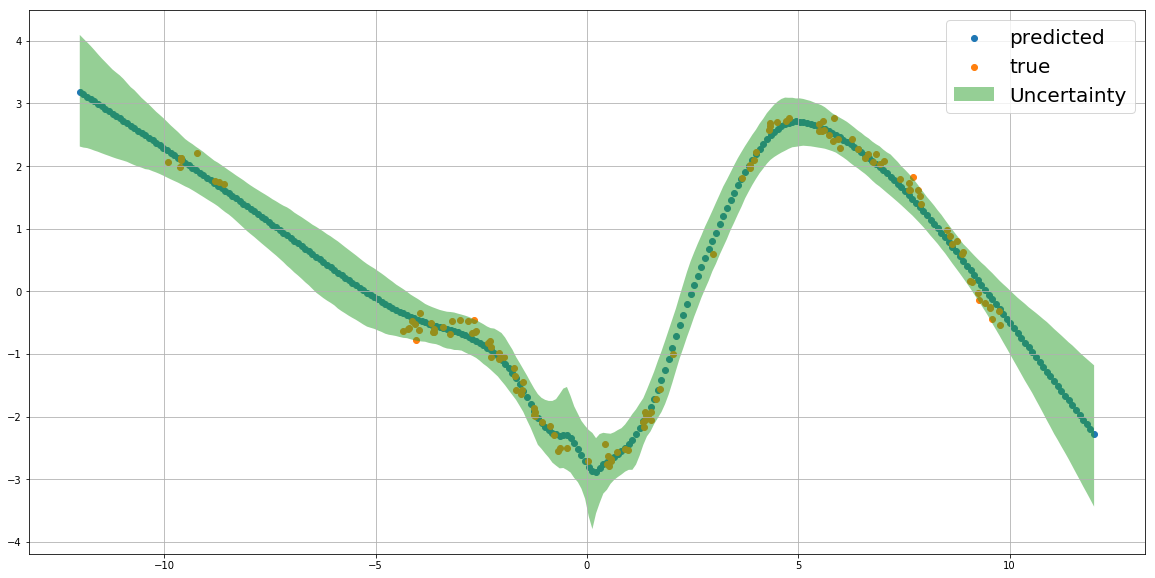

In [16]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.grid()
plt.scatter(Xtest, mean, label='predicted')
plt.scatter(X, y, label='true')
plt.fill_between(np.array(Xtest).ravel(), 
                 percentile5,
                 percentile95,
                 alpha=0.5, label='Uncertainty')
plt.legend(fontsize=20)
plt.savefig("imgs/MetropolisRegression.png")
plt.show()

# Stochastic Gradient Hamiltonian Monte Carlo

<p>Instead of computing the costly gradient $\nabla U(\theta)$ on the entire dataset $D$, we consider a minibatch $\tilde{D}$ sampled uniformly at random from $D$:
    \begin{equation} \nabla \tilde{U}(\theta) = - \frac{|D|}{|\tilde{D}|} \sum_{x \in \tilde{D}} \nabla log~p(x|\theta)-\nabla log~p(\theta), \quad \tilde{D} \subset D
    \end{equation}</p>
<p>This noisy gradient we assume that can be approximated with:
    \begin{equation} \nabla \tilde{U}(\theta) ≈ \nabla U(\theta)+ N(0, V(\theta)) \end{equation}
    with $V(\theta)$ a covariance matrix depending on the model parameters. As $\tilde{D}$ increases, for the central limit theorem this introduction of a Gaussian random variable become more accurate. Empirically a minibatch in othe order of hundreds of data points is sufficient for the central limit theorem to be accurate</p>

In [20]:
import torch
import numpy as np


## Base Sampler class
## -----------------------------------------------------------------------------

class _BaseSampler:

    def __init__(self, loss_module):
        self.loss_module = loss_module
        self.sampled_weights = []

    def sample(self, nsamples=1, **args):
        raise NotImplementedError()

    def get_weights(self):
        params = self.loss_module.parameters()
        return tuple(p.data.clone().detach().cpu().numpy() for p in params)

    def set_weights(self, weights):
        for p, sample in zip(self.loss_module.parameters(), weights):
            p.copy_(torch.from_numpy(sample))

    def predict(self, x):
        with torch.no_grad():
            f_samples = np.ndarray((x.shape[0], len(self.sampled_weights)))
            for i, weights in enumerate(self.sampled_weights):
                self.set_weights(weights)
                f = self.loss_module.predict(x)
                if f.ndim==1 or f.shape[1]==1:
                    f_samples[:,i] = f.flatten()
                else:
                    f_samples[:,:,i] = f
            return f_samples

    def get_sampled_weight_matrix(self):
        if len(self.sampled_weights)==0:
            return None
        n_params = 0
        for w in self.sampled_weights[0]:
            n_params += w.size
        w_matrix = np.zeros([len(self.sampled_weights), n_params])
        for idx, weights in enumerate(self.sampled_weights):
            j0 = 0
            for w in weights:
                w_vec = w.flatten()
                length = w_vec.size
                w_matrix[idx, j0:(j0+length)] = w_vec
                j0 += length
        return w_matrix


## (Adaptive) Stochastic Gradient HMC Sampler classes
## -----------------------------------------------------------------------------

class AdaptiveSGHMC(torch.optim.Optimizer):
    """ Stochastic Gradient Hamiltonian Monte-Carlo Sampler that uses a burn-in
        procedure to adapt its own hyperparameters during the initial stages
        of sampling.

        References:
        [1] http://aad.informatik.uni-freiburg.de/papers/16-NIPS-BOHamiANN.pdf
        [2] https://arxiv.org/pdf/1402.4102.pdf
    """

    def __init__(self, params, lr=1e-2, num_burn_in_steps=3000,
                 epsilon=1e-10, mdecay=0.05, scale_grad=1.):
        """ Set up a Adaptive SGHMC Optimizer.

        Args:
            params: iterable, parameters serving as optimization variable.
            lr: float, base learning rate for this optimizer.
                Must be tuned to the specific function being minimized.
            num_burn_in_steps: int, bumber of burn-in steps to perform.
                In each burn-in step, this sampler will adapt its own internal
                parameters to decrease its error. Set to `0` to turn scale
                adaption off.
            epsilon: float, per-parameter epsilon level.
            mdecay:float, momentum decay per time-step.
            scale_grad: float, optional
                Value that is used to scale the magnitude of the epsilon used
                during sampling. In a typical batches-of-data setting this
                usually corresponds to the number of examples in the
                entire dataset.
        """
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if num_burn_in_steps < 0:
            raise ValueError("Invalid num_burn_in_steps: {}".format(
                num_burn_in_steps))

        defaults = dict(
            lr=lr, scale_grad=float(scale_grad),
            num_burn_in_steps=num_burn_in_steps,
            mdecay=mdecay,
            epsilon=epsilon
        )
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None

        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for parameter in group["params"]:

                if parameter.grad is None:
                    continue

                state = self.state[parameter]

                if len(state) == 0:
                    state["iteration"] = 0
                    state["tau"] = torch.ones_like(parameter)
                    state["g"] = torch.ones_like(parameter)
                    state["v_hat"] = torch.ones_like(parameter)
                    state["momentum"] = torch.zeros_like(parameter)
                state["iteration"] += 1

                mdecay = group["mdecay"]
                epsilon = group["epsilon"]
                lr = group["lr"]
                scale_grad = torch.tensor(group["scale_grad"],
                                          dtype=parameter.dtype)
                tau, g, v_hat = state["tau"], state["g"], state["v_hat"]

                momentum = state["momentum"]
                gradient = parameter.grad.data * scale_grad

                tau_inv = 1. / (tau + 1.)

                # Update parameters during burn-in
                if state["iteration"] <= group["num_burn_in_steps"]:
                    # Specifies the moving average window, see Eq 9 in [1] left
                    tau.add_(- tau * (
                            g * g / (v_hat + epsilon)) + 1)

                    # Average gradient see Eq 9 in [1] right
                    g.add_(-g * tau_inv + tau_inv * gradient)

                    # Gradient variance see Eq 8 in [1]
                    v_hat.add_(-v_hat * tau_inv + tau_inv * (gradient ** 2))

                # Preconditioner
                minv_t = 1. / (torch.sqrt(v_hat) + epsilon)  

                epsilon_var = (2. * (lr ** 2) * mdecay * minv_t - (lr ** 4))

                # Sample random epsilon
                sigma = torch.sqrt(torch.clamp(epsilon_var, min=1e-16))
                sample_t = torch.normal(mean=torch.zeros_like(gradient),
                                        std=torch.ones_like(gradient) * sigma)

                # Update momentum (Eq 10 right in [1])
                momentum.add_(
                    - (lr ** 2) * minv_t * gradient - mdecay * momentum + sample_t
                )

                # Update parameters (Eq 10 left in [1])
                parameter.data.add_(momentum)

        return loss



class SGHMCSampler(_BaseSampler):

    def __init__(self, loss_module, num_burn_in_steps=3000, lr=0.001, 
        keep_every=1, mdecay=0.01):
        super(SGHMCSampler, self).__init__(loss_module)
        self.N = loss_module.X.shape[0]
        self.walker = AdaptiveSGHMC(loss_module.parameters(), lr=lr, 
            num_burn_in_steps=num_burn_in_steps, mdecay=mdecay, scale_grad=self.N)
        self.num_burn_in_steps = num_burn_in_steps
        self.keep_every = keep_every

    def sample(self,nsamples=1, nchains=1, **args):
        keep_every = self.keep_every
        num_burn_in_steps = self.num_burn_in_steps
        n_samples_per_chain = nsamples // nchains

        for step in range(nsamples * keep_every + num_burn_in_steps):
            if (step+1)%(nsamples*keep_every/10)==0:
                print("Sampling {}/{}".format(step+1, nsamples * keep_every + num_burn_in_steps))
            self.walker.zero_grad()
            loss = self.loss_module() / self.N 
            loss.backward()
            ## NOTE: do not use this; it rescales the gradient and it is ugly!
            ## Instead, use larger mdecay or smaller lr
            ##torch.nn.utils.clip_grad_norm_(self.loss_module.parameters(), 100.)
            self.walker.step()

            if (step > num_burn_in_steps) and \
                    ((step - num_burn_in_steps) % keep_every == keep_every-1):
                self.sampled_weights.append(self.get_weights())
                if len(self.sampled_weights) % n_samples_per_chain == 0:
                    self.loss_module.initialise()
                    

import torch.nn as nn

class LossModule(nn.Module):
    def __init__(self, model,train, loss):
        super(LossModule, self).__init__()
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model = model.to(self.device)
        self.X = train[0].to(self.device)
        self.labels = train[1].to(self.device)
        self.loss_fn = loss
        
    def negative_log_prior(self,params):
        regularization_term = 0
        for name, W in params:
            regularization_term += W.norm(2)
        return 0.5*regularization_term

    def parameters(self):
        return self.model.parameters()
    
    def forward(self):
        outputs = self.model(self.X)
        loss = self.loss_fn(outputs, self.labels) + self.negative_log_prior(self.model.named_parameters())
        return loss
    
    def initialise(self):
        pass
        

## Classification

In [37]:
class SimpleDataClassification(Dataset):
    """Online News Popularity dataset."""

    def __init__(self, X,y, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X, self.Y = X,y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            print(idx)
            idx = idx.tolist()
        x,y = self.X[idx,:], self.Y[idx]
        x,y = self.transform(x,y)
        return (x,y)


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, x,y):
        return torch.from_numpy(np.array(x)).type(torch.FloatTensor), torch.Tensor([y]).type(torch.FloatTensor).squeeze()


data = np.loadtxt('dataSimple/example_data.txt', delimiter=',')
X = data[:,0]
y = data[:,2]
X = np.reshape(X,(X.shape[0],1))
N = X.shape[0] 
M = 280
a, b = np.floor(min(X)), np.ceil(max(X))    
Xtest = torch.from_numpy(np.linspace(a-2, b+2, M).reshape(-1,1)).type(torch.FloatTensor)
transform = ToTensor()
dataset = SimpleDataClassification(X,y, transform = transform)
train_loader = DataLoader(dataset, batch_size=1,
                        shuffle=True, num_workers=0)

In [38]:
model = NetClass()
loss_fn = torch.nn.BCELoss(reduction='sum')
lm = LossModule(model, train_loader, loss_fn,temperature = None)
SGHMC = SGHMCSampler(lm, num_burn_in_steps=5000, lr=0.002, keep_every = 200, mdecay=0.01)
SGHMC.sample(train_loader,Xtest,model,nsamples=1000)
sampled_weights = SGHMC.sampled_weights

cpu


/mnt/workspace/.local/lib/python3.5/site-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Sampling 41000/205000
Sampling 82000/205000
Sampling 123000/205000
Sampling 164000/205000
Sampling 205000/205000


In [39]:
outputs = torch.zeros((Xtest.size()[0], len(sampled_weights)))

for j,sample in enumerate(sampled_weights):
    state_dict = {}
    for i,(name, param) in enumerate(model.named_parameters()):
        state_dict[name] = torch.from_numpy(sample[i])
    state_dict_it = OrderedDict(state_dict)
    model.load_state_dict(state_dict_it, strict=False)
    with torch.no_grad():
        outputs[:,j] = torch.squeeze(model(Xtest))
percentile5, percentile95 = np.percentile(outputs.numpy(),5, axis=1), np.percentile(outputs.numpy(),95, axis=1)
mean = torch.mean(outputs, 1)

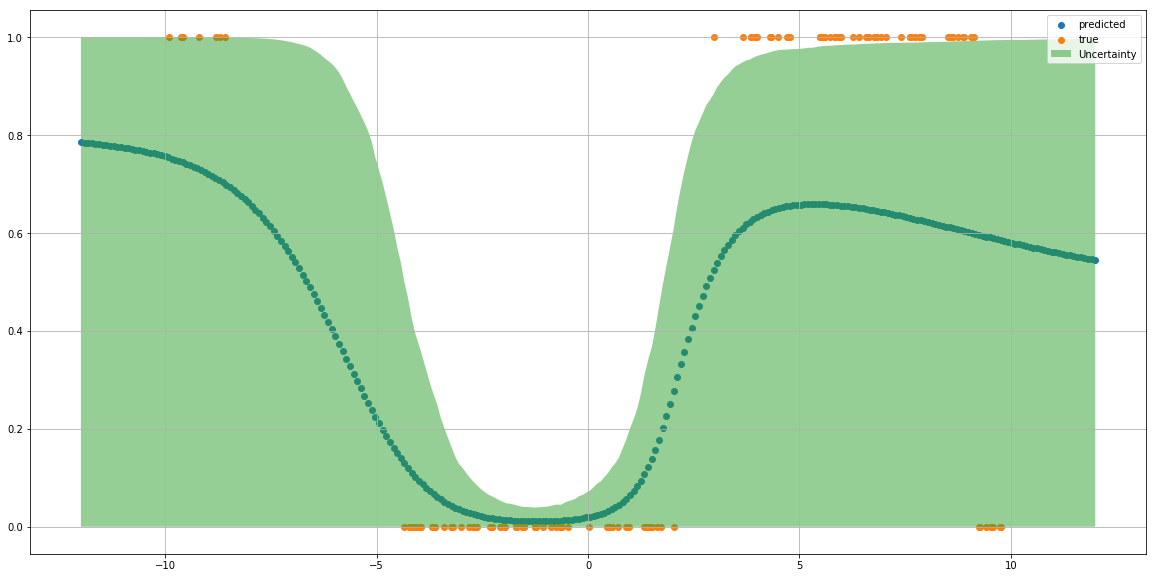

In [40]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.grid()
plt.scatter(Xtest, mean, label='predicted')
plt.scatter(X, y, label='true')
plt.fill_between(np.array(Xtest).ravel(), 
                 percentile5,
                 percentile95,
                 alpha=0.5, label='Uncertainty')
plt.legend()
plt.show()

## Regression

In [41]:
class SimpleDataRegression(Dataset):
    """Online News Popularity dataset."""

    def __init__(self, X,y, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X, self.Y = X,y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            print(idx)
            idx = idx.tolist()
        x,y = self.X[idx,:], self.Y[idx]
        x,y = self.transform(x,y)
        return (x,y)


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, x,y):
        return torch.from_numpy(np.array(x)).type(torch.FloatTensor), torch.Tensor([y]).type(torch.FloatTensor).squeeze()
    
data = np.loadtxt('dataSimple/example_data.txt', delimiter=',')
X = data[:,0]
y = data[:,1]
X = np.reshape(X,(X.shape[0],1))
N = X.shape[0] 
M = 280
a, b = np.floor(min(X)), np.ceil(max(X))    
Xtest = torch.from_numpy(np.linspace(a-2, b+2, M).reshape(-1,1)).type(torch.FloatTensor)
transform = ToTensor()
dataset = SimpleDataClassification(X,y, transform = transform)
train_loader = DataLoader(dataset, batch_size=1,
                        shuffle=True, num_workers=0)

In [48]:
model = NetRegr()
loss_fn = torch.nn.MSELoss(reduction='sum')
lm = LossModule(model, train_loader, loss_fn, temperature = None)
#SGHMC = SGHMCSampler(lm, num_burn_in_steps=5000, lr=0.003, keep_every=50)
#SGHMC.sample(train_loader,Xtest,model,nsamples=100)
SGHMC = SGHMCSampler(lm, num_burn_in_steps=5000, lr=0.001, keep_every=200)
SGHMC.sample(train_loader,Xtest,model,nsamples=1000)
sampled_weights = SGHMC.sampled_weights

cpu


/mnt/workspace/.local/lib/python3.5/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sampling 41000/205000
Sampling 82000/205000
Sampling 123000/205000
Sampling 164000/205000
Sampling 205000/205000


In [49]:
outputs = torch.zeros((Xtest.size()[0], len(sampled_weights)))
for j,sample in enumerate(sampled_weights):
    state_dict = {}
    for i,(name, param) in enumerate(model.named_parameters()):
        state_dict[name] = torch.from_numpy(sample[i])
    state_dict_it = OrderedDict(state_dict)
    model.load_state_dict(state_dict_it, strict=False)
    with torch.no_grad():
        outputs[:,j] = torch.squeeze(model(Xtest))
percentile5, percentile95 = np.percentile(outputs.numpy(),5, axis=1), np.percentile(outputs.numpy(),95, axis=1)
mean = torch.mean(outputs, 1)

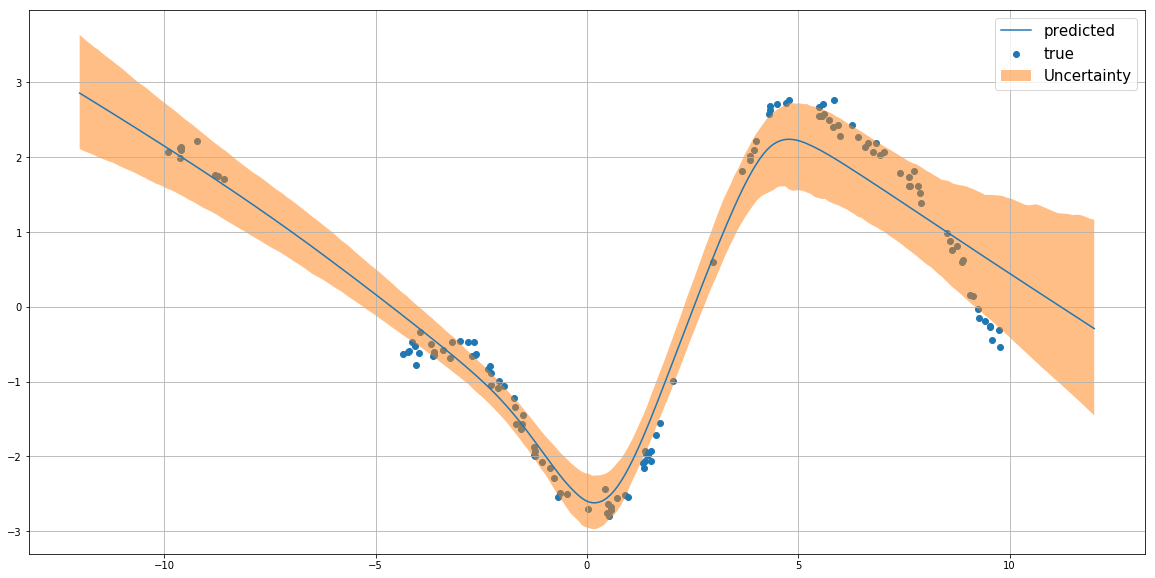

In [50]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(Xtest, mean, label='predicted')
plt.scatter(X, y, label='true')
plt.fill_between(np.array(Xtest).ravel(), 
                 percentile5, 
                 percentile95, 
                 alpha=0.5, label='Uncertainty')
plt.legend(fontsize=15)
plt.savefig("imgs/SGHMCRegression.png")
plt.show()